In [1]:
import keras
from keras import regularizers, optimizers
from keras import losses
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Input, Dropout, Embedding, LSTM
from keras.optimizers import RMSprop, Adam, Nadam
from keras.preprocessing import sequence

from keras.layers import Conv1D, Flatten, Activation, SpatialDropout1D
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.utils import to_categorical

import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
 
from sklearn.metrics import confusion_matrix, roc_auc_score,precision_recall_curve,auc
from sklearn.metrics import classification_report

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

import tensorflow 
import sys
print("Python: ", sys.version)

print("pandas: ", pd.__version__)
print("numpy: ", np.__version__)
print("seaborn: ", sns.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn: ", sklearn.__version__)
print("Keras: ", keras.__version__)
print("Tensorflow: ", tensorflow.__version__)


Using TensorFlow backend.


Python:  3.7.0 (default, Jun 28 2018, 08:04:48) [MSC v.1912 64 bit (AMD64)]
pandas:  0.23.4
numpy:  1.19.1
seaborn:  0.9.0
matplotlib:  2.2.3
sklearn:  0.19.2
Keras:  2.3.1
Tensorflow:  2.1.0


In [2]:
columns = ["duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land", "wrong_fragment", "urgent",
        "hot", "num_failed_logins", "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root", 
        "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login",
        "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate",
        "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count", 
        "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate",
        "dst_host_serror_rate", "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"]

df = pd.read_csv("../data/kddcup.data.corrected", sep=",", names=columns, index_col=None)
print(df.shape)
pd.options.display.max_columns = None
df.head(5)

(4898431, 42)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,215,45076,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,162,4528,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,236,1228,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,233,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3,3,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,normal.


In [10]:
normal=df[(df["label"]=="normal.")&(df["src_bytes"]>0)&(df["src_bytes"]<300)]
normal=normal[["src_bytes","label"]]
print(normal["label"].value_counts())
#选出600000多数据用于分配和标准化
scaler= MinMaxScaler(feature_range = (0,1))
normal['value'] = pd.DataFrame(scaler.fit_transform(pd.DataFrame(normal['src_bytes'])),columns=['src_bytes'])
normal=normal.dropna(axis=0,how='any')
normal=normal[normal["value"]>0]
normal=np.array(normal['value'])
print("normal:",normal)
timesquen=20
trim=len(normal)%timesquen
normal=normal[:len(normal)-trim]
normal.shape=(int(len(normal)/timesquen),timesquen,1)
print("normal",normal.shape)
train=normal[0:7000]
#validation=np.concatenate((normal[6000:10000],abnormal[0:1000]),axis=0)
#np.random.shuffle(validation)
#test=np.concatenate((normal[10000:12000],abnormal[0:800]),axis=0)
#np.random.shuffle(test)
validation=np.loadtxt('../data/collective_validation.csv',delimiter = ",")
test=np.loadtxt('../data/collective_test.csv',delimiter=",")

validation.shape=(int(len(validation)/timesquen),timesquen,1)
test.shape=(int(len(test)/timesquen),timesquen,1)
print(train.shape,validation.shape,test.shape)


normal.    622729
Name: label, dtype: int64
normal: [0.71812081 0.54026846 0.7885906  ... 0.34899329 0.09731544 0.34899329]
normal (12457, 20, 1)
(7000, 20, 1) (5000, 20, 1) (2800, 20, 1)


In [11]:
# convolutional layer parameters
from keras.layers import  Lambda
n_filters = 32 
filter_width = 2
dilation_rates = [2**i for i in range(4)] 
# define an input history series and pass it through a stack of dilated causal convolutions. 
history_seq = Input(shape=(None, 1))
x = history_seq
for dilation_rate in dilation_rates:
    x = Conv1D(filters=n_filters,
               kernel_size=filter_width, 
              kernel_regularizer=regularizers.l2(0.02),
                padding='causal',
               dilation_rate=dilation_rate,activation='relu')(x)

x = Dense(128, activation='relu')(x)
x = Dropout(.2)(x)
x = Dense(1)(x)
# extract the last 14 time steps as the training target
def slice(x, seq_length):
    return x[:,-seq_length:,:]
pred_seq_train = Lambda(slice, arguments={'seq_length':timesquen})(x)

TCN = Model(history_seq, pred_seq_train)
TCN.compile(optimizer=optimizers.Adam(), loss='mean_absolute_error')
TCN.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, 1)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 32)          96        
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_7 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_8 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
dense_3 (Dense)              (None, None, 128)         4224      
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 128)         0   

In [12]:
from keras.callbacks import TensorBoard
tensorboard=tensorflow.keras.callbacks.TensorBoard(histogram_freq=1)
history=TCN.fit(train, train,
          batch_size=2**10,
          epochs=27,
          validation_data=(validation, validation))
         # callbacks = [tensorboard])


Train on 7000 samples, validate on 5000 samples
Epoch 1/27
7000/7000 [==============================] - 7s 973us/step - loss: 2.5847 - val_loss: 2.2240
Epoch 2/27
7000/7000 [==============================] - 3s 412us/step - loss: 2.3016 - val_loss: 1.9804
Epoch 3/27
7000/7000 [==============================] - 3s 418us/step - loss: 1.9388 - val_loss: 1.7112
Epoch 4/27
7000/7000 [==============================] - 3s 439us/step - loss: 1.6368 - val_loss: 1.6434
Epoch 5/27
7000/7000 [==============================] - 3s 458us/step - loss: 1.4765 - val_loss: 1.4634
Epoch 6/27
7000/7000 [==============================] - 3s 439us/step - loss: 1.3379 - val_loss: 1.3567
Epoch 7/27
7000/7000 [==============================] - 3s 436us/step - loss: 1.2161 - val_loss: 1.2671
Epoch 8/27
7000/7000 [==============================] - 3s 437us/step - loss: 1.1122 - val_loss: 1.1669
Epoch 9/27
7000/7000 [==============================] - 3s 430us/step - loss: 1.0200 - val_loss: 1.0887
Epoch 10/27
7000

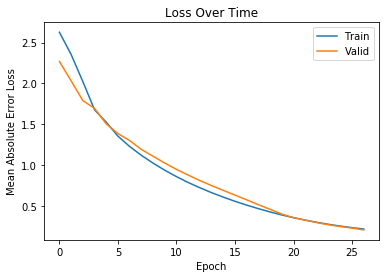

In [8]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

In [13]:
test_pred = TCN.predict(test)
print(test_pred.shape)


(2800, 20, 1)


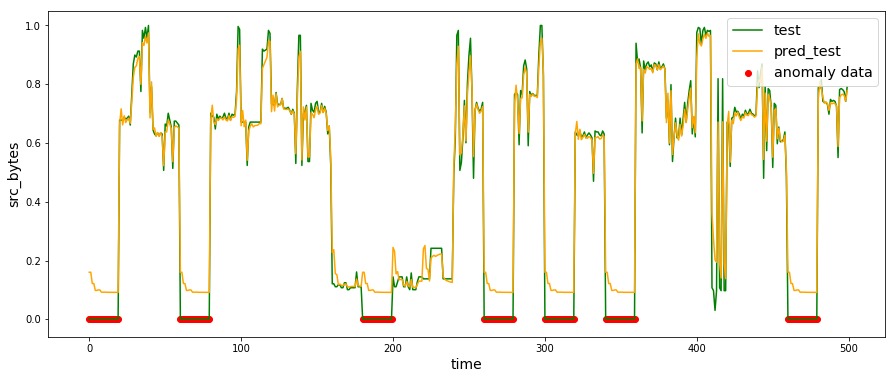

In [14]:
train1=train.reshape(train.shape[0]*train.shape[1],1)
test1=test.reshape(test.shape[0]*test.shape[1],1)
test_pred1=test_pred.reshape(test_pred.shape[0]*test_pred.shape[1],1)
plt.figure(figsize=(15,6))
plt.xlabel('time',fontsize=14)
plt.ylabel('src_bytes',fontsize=14)
plt.plot(test1[0:500],color="green")
plt.plot(test_pred1[0:500],color="orange",linestyle='-')
for i in range(500):
    if test1[i][0] == 0.001:
         plt.scatter(i,test1[i][0],color="red")
plt.legend(('test','pred_test','anomaly data'),loc='upper right',fontsize='x-large')


In [15]:
#点集检测
pred_label=[]
for i in range(len(test1)):
    pred_label.append(0)#正常

PAsum_rela_erro=np.zeros((len(pred_label)), dtype = float)
for i in range(len(pred_label)):
    PAsum_rela_erro[i]=np.abs(test1[i]-test_pred1[i])
PAscores=PAsum_rela_erro.copy()
PAscores.sort()
print(PAscores)

PAthreshold=1#PAscores[PAcutoff]
print(PAthreshold)
for i in range(len(test1)):
    if PAsum_rela_erro[i] > PAthreshold:
        pred_label[i]=2 #异常


[3.86430113e-07 9.08870825e-07 9.91777286e-07 ... 2.34253203e-01
 2.42064858e-01 2.51509831e-01]
1


In [16]:
normal_rela_erro=0.0008
#集体集检测
timestep=10
n=int(len(pred_label)/timestep)
CAsum_rela_erro=np.zeros(n+1, dtype = float)
for i in range(0,len(test1),timestep):
    for j in range(timestep):
            if ((i+j)<len(pred_label)) and (pred_label[i+j]==0):
                rela_erro=np.abs(test1[i+j]-test_pred1[i+j])
                CAsum_rela_erro[int(i/timestep)]=rela_erro+CAsum_rela_erro[int(i/timestep)]
              #  print()
            else:
                CAsum_rela_erro[int(i/timestep)]=normal_rela_erro+CAsum_rela_erro[int(i/timestep)]
                
                
                
CAscores=CAsum_rela_erro.copy()
CAscores.sort()
print(CAscores)

        

[0.         0.02045072 0.02237647 ... 1.13374189 1.15397972 1.25562999]


In [17]:
CAcutoff=int(0.70*len(CAscores))
CAthreshold=CAscores[CAcutoff]
print(CAscores[CAcutoff])

0.46262907741853865


In [18]:
for i in range(n+1):
    if CAsum_rela_erro[i] > CAthreshold:
        for j in range(timestep):
            if i*timestep+j<len(pred_label) and pred_label[i*timestep+j]!=2:
                pred_label[i*timestep+j]=1

In [19]:
print(pred_label)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [20]:
test_label=[]
for i in range(len(test1)):
    if test1[i]!= 0.001:
        test_label.append(0)#正常
    else :
        test_label.append(1)#异常

In [21]:
Perro_x=[]
Perro_y=[]
Cerro_x=[]
Cerro_y=[]
for i in range(500):
    if pred_label[i]==2:
        Perro_x.append(i)
        Perro_y.append(test1[i])
    elif pred_label[i]==1:
        Cerro_x.append(i)
        Cerro_y.append(test1[i])

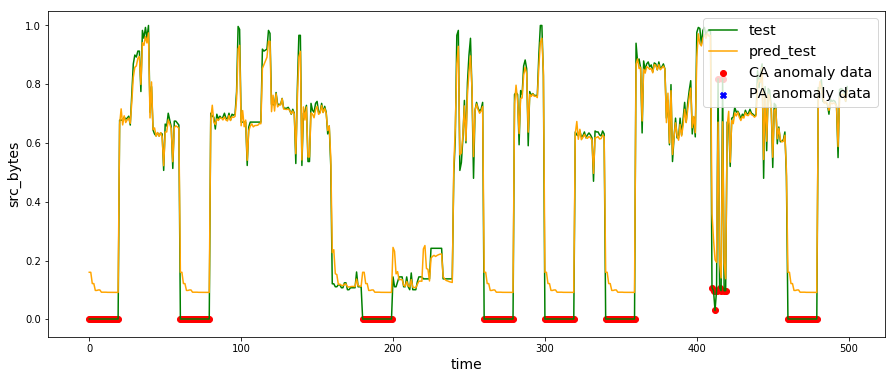

In [22]:
test_pred1=test_pred.reshape(test_pred.shape[0]*test_pred.shape[1],1)
plt.figure(figsize=(15,6))
plt.xlabel('time',fontsize=14)
plt.ylabel('src_bytes',fontsize=14)
plt.plot(test1[0:500],color="green")
plt.plot(test_pred1[0:500],color="orange",linestyle='-')
plt.scatter(Cerro_x,Cerro_y,color="red",label='CA_data')
plt.scatter(Perro_x,Perro_y,color="blue",marker="X",label='PA_data')          
plt.legend(('test','pred_test','CA anomaly data','PA anomaly data'),loc='upper right',fontsize='x-large')

In [23]:
Pred_label=[]
for i in range(len(pred_label)):
    if pred_label[i]==0:
        Pred_label.append(0)
    else:
        Pred_label.append(1)
        

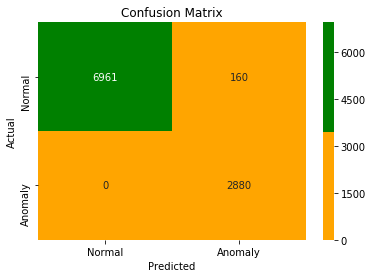

In [29]:
class Visualization:
    labels = ["Normal", "Anomaly"]

    def draw_confusion_matrix(self, y, ypred):
        matrix = confusion_matrix(y, ypred)

        plt.figure(figsize=(6, 4))
        colors=[ "orange","green"]
        sns.heatmap(matrix, xticklabels=self.labels, yticklabels=self.labels, cmap=colors, annot=True, fmt="d")
        plt.title("Confusion Matrix")
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()

viz = Visualization()
viz.draw_confusion_matrix(test_label[25000:35001],Pred_label[25000:35001])

In [30]:
print("CA:",pred_label.count(1))
print("PA:",pred_label.count(2))
ROC_AUC=roc_auc_score(test_label,Pred_label)
print("ROC_AUC score:{:2%}".format(ROC_AUC))  
precision, recall, _thresholds = precision_recall_curve(test_label, Pred_label)
PR_AUC = auc(recall, precision)
print("PR_AUC score:{:2%}".format(PR_AUC))

CA: 16800
PA: 0
ROC_AUC score:99.000000%
PR_AUC score:97.619048%
